In [124]:
import os
import glob
import numpy as np
import itertools
import random
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

from skimage import feature
from PIL import Image, ImageOps
import pywt
import matplotlib.pyplot as plt

from scipy import ndimage

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import moment

from skimage.restoration import denoise_wavelet
%matplotlib inline

In [125]:
path2train = 'data/train/'
path2test = 'data/test'

In [126]:
img_width = img_height=256

In [127]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


In [128]:
def preProcessing(img, row=0, col=0, center=True):
    
    '''img = resizeImage(img) # cant resize the image!!
    img = RGB2Gray(img) #cant transform to rgb!'''
    
    if center:
        img = crop_image_center(img)
    else:
        img = crop_image_corners(img, row=row, col=col)

    img = noise_wavelet(img)
    #img = noise_median(img)
    #img = localBinaryPatterns(img)
    #img = addDelta(img)
    #img = vectorizeImage(img, nb_channels=3)
    return img

In [129]:
def crop_image_corners(img, row, col, img_width=128, img_height=128):

    width, height = img.size   # Get dimensions

    x = row*(width-img_width)
    y = col*(height-img_height)
    crop = img.crop((x, y, x + w, y + h))
    
    return crop

In [130]:
def crop_image_center(img, img_width=128, img_height=128):
    width, height = img.size   # Get dimensions

    left = (width - img_width)/2
    top = (height - img_height)/2
    right = (width + img_width)/2
    bottom = (height + img_height)/2

    crop = img.crop((left, top, right, bottom))
    return crop

In [131]:
def RandomCropImage(img, img_width=128, img_height=128):
    
    width, height = img.size   # Get dimensions

    idx_width = random.randint(0, width - img_width)
    idx_height = random.randint(0, height - img_height)

    return img.crop((idx_width, idx_height, idx_width+img_width, idx_height + img_height))

In [132]:
def vectorizeImage(img, img_width=128, img_height=128, nb_channels = 1):
    return img.reshape(-1,img_width * img_height * nb_channels)

In [133]:
def noise_median(img, factor=2):
    return img - ndimage.median_filter(img, factor)

In [134]:
def resizeImage(img, img_width=128, img_height=128):
    img = img.resize((img_width, img_height))
    return np.array(img)

In [135]:
def localBinaryPatterns(img, numPoints=24, radius=2):
    
    img_lbp = np.zeros(np.array(img).shape)
    for i in range(np.array(img).shape[2]):
        img_lbp[:,:,i] = feature.local_binary_pattern(img.getchannel(i), numPoints,
                    radius, method="uniform")
    return img_lbp

In [136]:
def noise_wavelet(img, n_moments=9):
    wav_noise = img - denoise_wavelet(img=img, multichannel=True)
    
    res = []
    for i in range(0, wav_noise.shape[2]):
        coeffs = pywt.dwt2(wav_noise[:,:,i], wavelet='haar')
        cA, (cH, cV, cD) = coeffs

        for j in range(0, n_moments):
            res.append(moment(cH.ravel(), moment=j))
            res.append(moment(cV.ravel(), moment=j))
            res.append(moment(cD.ravel(), moment=j))
    return res

In [137]:
def RGB2Gray(img):
    img = np.array(img)
    return np.dot(img[...,:3], [0.299, 0.587, 0.114]).astype(int)

In [138]:
def extractImage(path):

    with Image.open(path) as img:
        img = preProcessing(img)
    target = path.split('/')[-2]
    return img, target

In [139]:
def extractImagesParallel(path, threads=2):
    pool = ThreadPool(threads)
    #imgs, targets = zip(*pool.map(extractImage, path))
    result = pool.map(extractImage, path)
    pool.close()
    pool.join()
    return result

In [140]:
def get_data(path, format_file = '*.jpg', is_train = True):
    results = []

    for subdir, dirs, files in os.walk(path):
        if subdir.split('/')[-1] != '':

            print('Reading files from dir: {}'.format(subdir))

            path_folder = os.path.join(subdir, format_file)
            filesPath = glob.glob(path_folder) 

            res  = extractImagesParallel(filesPath, cpu_count)
            results.append(res)
    
    flattened_list = [y for x in results for y in x]
    X, y = map(list, zip(*flattened_list))

    X = np.array(X)
    y = np.array(y)
    
    if np.array(X).shape[1] == 1:
        X = np.squeeze(X, axis=1)
    
    return X, y

In [141]:
print('Reading training data...\n')
X, y = get_data(path2train)
print('Reading testing data...')
X_test, _ = get_data(path2test, format_file='*.tif', is_train=False)

Reading training data...

Reading files from dir: data/train/iPhone-4s
Reading files from dir: data/train/Motorola-Droid-Maxx
Reading files from dir: data/train/HTC-1-M7
Reading files from dir: data/train/Samsung-Galaxy-S4
Reading files from dir: data/train/Motorola-X
Reading files from dir: data/train/Motorola-Nexus-6
Reading files from dir: data/train/LG-Nexus-5x
Reading files from dir: data/train/Samsung-Galaxy-Note3
Reading files from dir: data/train/iPhone-6
Reading files from dir: data/train/Sony-NEX-7
Reading testing data...
Reading files from dir: data/test


In [142]:
test_size = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

In [143]:
print('Shape of the training data X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('Shape of the valid data X: {}, y: {}'.format(X_valid.shape, y_valid.shape))

Shape of the training data X: (2200, 81), y: (2200,)
Shape of the valid data X: (550, 81), y: (550,)


### Normalization

In [144]:
normalization_type = 'zScore'

In [145]:
print('Normalization type: {}'.format(normalization_type))

if normalization_type == 'minMax':
    scaler = MinMaxScaler()
    
elif normalization_type == 'zScore':        
    scaler =  StandardScaler()
    
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

Normalization type: zScore


# Model

### Logistic Regression

In [146]:
lr_model = linear_model.LogisticRegression(max_iter=10)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_valid)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(lr_model.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on valid set: {:.2f}'.format(lr_model.score(X_valid, y_valid)))

Accuracy of logistic regression classifier on train set: 0.31
Accuracy of logistic regression classifier on valid set: 0.25


### Neural Network

In [154]:
mlp_model = MLPClassifier(hidden_layer_sizes=(256,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=1, tol=1e-4, random_state=1,
                    learning_rate_init=.1)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_valid)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(mlp_model.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on valid set: {:.2f}'.format(mlp_model.score(X_valid, y_valid)))

Iteration 1, loss = 2.28745602
Iteration 2, loss = 2.17482566
Iteration 3, loss = 2.13728519
Iteration 4, loss = 2.08666189
Iteration 5, loss = 2.05299900
Iteration 6, loss = 2.03697984
Iteration 7, loss = 2.01578423
Iteration 8, loss = 1.99919111
Iteration 9, loss = 1.98244636
Iteration 10, loss = 1.96282601
Iteration 11, loss = 1.95041507
Iteration 12, loss = 1.94346346
Iteration 13, loss = 1.93274781
Iteration 14, loss = 1.92519017
Iteration 15, loss = 1.91252243
Iteration 16, loss = 1.91347680
Iteration 17, loss = 1.90148761
Iteration 18, loss = 1.87813787
Iteration 19, loss = 1.86949406
Iteration 20, loss = 1.86770711
Iteration 21, loss = 1.85989584
Iteration 22, loss = 1.86652007
Iteration 23, loss = 1.86026197
Iteration 24, loss = 1.85749067
Iteration 25, loss = 1.90484222
Iteration 26, loss = 1.85449459
Iteration 27, loss = 1.82310234
Iteration 28, loss = 1.81176638
Iteration 29, loss = 1.79843159
Iteration 30, loss = 1.79340211
Iteration 31, loss = 1.78284472
Iteration 32, los

In [155]:
cm_lr = confusion_matrix(y_valid, y_pred_lr)
cm_mlp = confusion_matrix(y_valid, y_pred_mlp)

#http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html

In [156]:
def plot_cm(cm, title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.title(title)

Normalized confusion matrix
Normalized confusion matrix


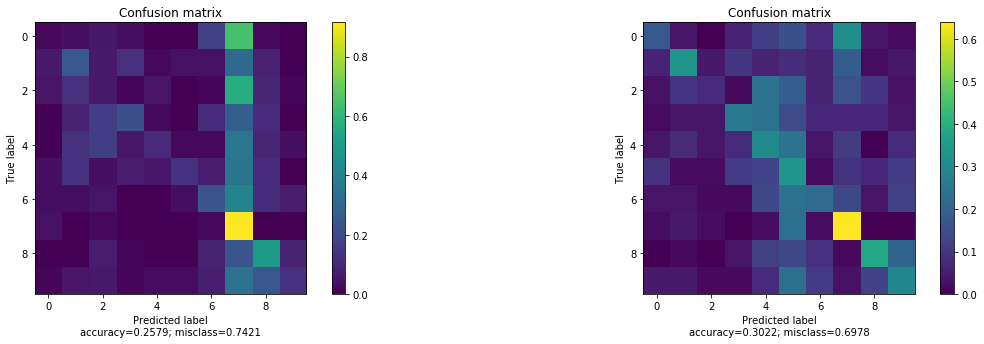

In [159]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plot_cm(cm_lr)

plt.subplot(1,2,2)
plot_cm(cm_mlp)

In [145]:
def showCamaraTransformations():

    plt.figure(figsize=(20,5))
    path = 'data/train/iPhone-4s/(iP4s)9.jpg'
    with Image.open(path) as img:
        plt.subplot(1,3,1)
        img = RGB2Gray(img)
        img_wav = denoise_wavelet(img)
        plt.imshow(np.round(img-img_wav), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,3,2)
        img_mean = median_filter(img, factor=4)
        plt.imshow(np.round(img-img_mean), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,3,3)
        img_lbp = localBinaryPatterns(img)
        plt.imshow(img_lbp, cmap='gray')
        plt.axis('off')
        
#showCamaraTransformations()

In [146]:
'''
path = 'data/train/iPhone-4s/(iP4s)9.jpg'
with Image.open(path) as img:
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs
print('cA {}'.format(cA.shape) )
print('cH: {}'.format(cH.shape) )
print('cV: {}'.format(cV.shape) )
print('cD: {}'.format(cD.shape) )
'''

"\npath = 'data/train/iPhone-4s/(iP4s)9.jpg'\nwith Image.open(path) as img:\n    coeffs = pywt.dwt2(img, 'haar')\n    cA, (cH, cV, cD) = coeffs\nprint('cA {}'.format(cA.shape) )\nprint('cH: {}'.format(cH.shape) )\nprint('cV: {}'.format(cV.shape) )\nprint('cD: {}'.format(cD.shape) )\n"

In [24]:
print(np.array(X).shape)
img_wav_filtered = denoise_wavelet(X, multichannel=True, convert2ycbcr=True,  mode='soft')

(2750, 16384)


/home/renatolr/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


ValueError: the input array must be have a shape == (.., ..,[ ..,] 3)), got (2750, 16384)

### Wavelet

In [ ]:
'''
import glob, os
folder = 'data/train/Sony-NEX-7'
for filename in glob.iglob(os.path.join(folder, '*.JPG')):
    os.rename(filename, filename[:-4] + '.jpg')
'''

In [ ]:
def showCamaraPhotos(X, y=[], is_train =True, img_width=128, img_height=128, nb_channels = 1):

    idx = random.randint(0,len(X))
    if is_train:
        plt.title(y[idx])
    img = X[idx].reshape(img_width, img_height, nb_channels)
    if nb_channels == 1:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    
plt.figure(figsize=(20,5))
for i in range(0, 3):
    plt.subplot(1,3,i+1)
    showCamaraPhotos(X, y, nb_channels=3)